# Attaque par JSMA sur un modèle de régression logistique

## Importation des dépendances

In [5]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from art.estimators.classification import SklearnClassifier
from art.attacks.evasion import SaliencyMapMethod
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

## 1. Importation des données et entraînement du modèle

### Importation des données MNIST

In [11]:
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root="./data", train=False, transform=transform)

On met en forme les données qui sont de dimension 2 en les aplatissant et en les standardisant

In [18]:
X_train = train_dataset.data.numpy().reshape(-1, 28 * 28) / 255.0
y_train = train_dataset.targets.numpy()
X_test = test_dataset.data.numpy().reshape(-1, 28 * 28) / 255.0
y_test = test_dataset.targets.numpy()

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Création du modèle et entraînement sur les données

In [24]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

On visualise ici le score du modèle sur les données de test 

In [27]:
accuracy = model.score(X_test, y_test)
print(f"Précision sur les données de test : {accuracy * 100:.2f}%")

Précision sur les données de test : 92.20%


## 2. Création du set de données adverse

### Adaptation du modèle au format ART 

In [34]:
classifier = SklearnClassifier(model=model, clip_values=(0, 1))

### Création d'un sous échantillon des données

On crée ici un sous échantillon des données d'entrée afin de créer des données adverses sur ce sous échantillon.

On effectue cela pour des raisons de coût computationnel, la JSMA étant assez coûteuse.

In [107]:
x_sample = X_test[:200]
y_sample = y_test[:200]

### Attaque JSMA sur le modèle pour produit des données adversarial

In [109]:
attack = SaliencyMapMethod(classifier=classifier, theta=0.1, gamma=0.1)
x_adv = attack.generate(x=x_sample)

JSMA:   0%|          | 0/200 [00:00<?, ?it/s]

## Comparaison des scores et prédictions

In [111]:
accuracy = model.score(X_test, y_test)
print(f"Précision sur les données de test : {accuracy * 100:.2f}%")

Précision sur les données de test : 92.20%


In [113]:
accuracy_adversarial = np.mean(classifier.predict(x_adv).argmax(axis=1) == y_sample)
print(f"Précision sur les données adversariales : {accuracy_adversarial * 100:.2f}%")

Précision sur les données adversariales : 0.50%


On observe une baisse considérable sur le score du modèle sur les données adverses

### Visualisation des prédictions du modèle

Affichage des prédictions par rapport aux données d'entrée

In [81]:
preds_original = np.argmax(classifier.predict(x_sample), axis=1)
preds_adversarial = np.argmax(classifier.predict(x_adv), axis=1)

print("Prédictions originales :", preds_original)
print("Prédictions adversariales :", preds_adversarial)

Prédictions originales : [7 2 1 0 4 1 4 9 6 9 0 6 9 0 1 5 9 7 2 4 9 6 6 5 4 0 7 4 0 1 3 1 3 6 7 2 7
 1 2 1 1 7 4 2 3 5 1 2 4 4]
Prédictions adversariales : [1 6 5 8 5 5 5 6 8 6 8 8 6 8 5 1 6 1 6 5 6 8 8 1 5 8 1 5 8 5 4 5 4 8 1 6 1
 5 6 5 5 1 5 6 4 1 5 6 5 5]


On remet les données sous le format d'image 28x28

In [79]:
x_sample_images = x_sample.reshape(-1, 28, 28)
x_adv_images = x_adv.reshape(-1, 28, 28)

Visualisation des prédictions

In [ ]:
i = 0

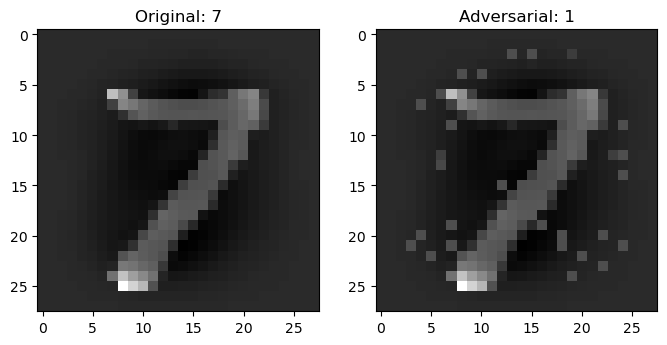

In [115]:
i += 1
if i == len(preds_original):
    i = 0

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title(f"Original: {preds_original[i]}")
plt.imshow(x_sample_images[i], cmap='gray')

plt.subplot(1, 2, 2)
plt.title(f"Adversarial: {preds_adversarial[i]}")
plt.imshow(x_adv_images[i], cmap='gray')
plt.show()

Affichage du bruit entre la donnée d'entrée d'origine et la donnée adverse

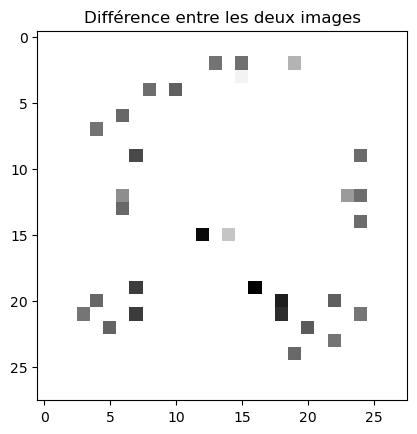

In [126]:
plt.figure()
plt.title("Différence entre les deux images")
plt.imshow(x_sample_images[i]-x_adv_images[i],cmap='gray')
plt.show()